In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import re
import jieba
import gensim
from sklearn.cross_validation import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
# 设置绘图字体为黑体
plt.rcParams['font.sans-serif'] = ['SimHei']

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# 读取评论数据
data = pd.read_csv(r'C:\Users\12517\PycharmProjects\NLP\projects\taptap评论情感分析\data\tap_reviews cleaned.csv', encoding='utf_8_sig')

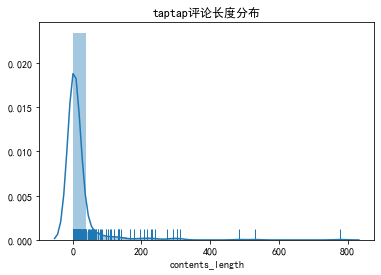

评论长度的9/10分位数： 123.0


In [3]:
# 查看评论长度分布
data['contents_length'] = data['contents'].apply(lambda x: len(str(x)))
len_se = data.groupby('contents_length')['contents_length'].count()
sns.distplot(len_se, bins=20, hist=True, kde=True, rug=True)
plt.title('taptap评论长度分布')
plt.show()
print('评论长度的9/10分位数：', data['contents_length'].quantile(0.9))
# 计算分位数发现，90%评论在123字内；密度图表明，评论长度集中在200字以内

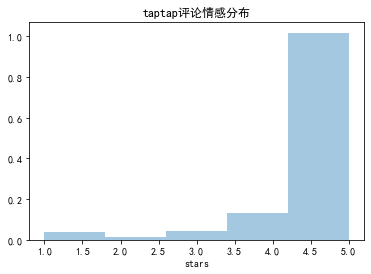

正面评价: 9101，占总数的92.12%    负面评价: 779, 占总数的7.88%


In [4]:
# 查看评论情感分布
positive = len(data['stars'][data['stars'] >= 4])
total = len(data['stars'])
negative = total - positive
sns.distplot(data['stars'], bins=5, kde=False, norm_hist=True)
plt.title('taptap评论情感分布')
plt.show()
print('正面评价: %d，占总数的%.2f%%    负面评价: %d, 占总数的%.2f%%' %
      (positive, (positive/total*100), negative, (negative/total*100)))
# 正面评价: 9101，占总数的92.12%    负面评价: 779, 占总数的7.88%， 满分评价占总体50%以上
# 这是标准的偏斜类数据，后续讨论模型效果时，需特别关注低分评价的预测准度

In [5]:
"""
文本挖掘的预处理,分五步：
1.去除非中文字符    2.进行中文分词   3.引入中文停用词   4.获取词向量特征   5.划分训练集和测试集
"""
# 模型中，X是玩家评论，Y是玩家标星；
# y值0-4对应1星-5星，转换原因是：torch内部根据数字索引进行独热处理，而索引从0开始，当类别只有5个时，y=5会触发tagert 5 out of bound的报错
X = data['contents']
Y = data['stars']-1                

In [6]:
# 去除非中文字符
def drop_non_chinese(text):
    """
    :param text: str,含非中文的字符串
    :return: str,不含非中文的字符串
    """
    # \u4e00-\u9fa5是中文字符的范围，中括号内^表示取反
    pattern = re.compile(r'[^\u4e00-\u9fa5]')
    chinese_text = re.sub(pattern, '', text)
    return chinese_text

# 中文分词
def split_text(chinese_text, cut_all=False):
    """
    :param chinese_text: str,中文文本
    :param cut_all: 是否采用全模式分词
    :return: str，用空格分隔的分词文本
    """
    text_generater = jieba.cut(chinese_text, cut_all=cut_all)
    result = ' '.join(text_generater)
    return result

# 去除中文停用词
def drop_stop_words(st_path, chinese_text):
    """
    :param st_path: str，停用词文件路径
    :param chinese_text: str，中文分词文本
    :return: list，去除停用词的中文分词列表
    """
    # 载入停用词列表
    with open(st_path, 'r') as f:
        st = f.read()
        st_list = st.splitlines()
    word_list = chinese_text.split()
    # 删除停用词
    for stop_word in st_list:
        word_list = [word for word in word_list if word != stop_word]
    return word_list

In [7]:
# 去除非中文字符
X = X.apply(lambda x: drop_non_chinese(str(x)))
# 中文分词
X = X.apply(lambda x: split_text(x))
# 3.去除中文停用词
X = X.apply(lambda x: drop_stop_words(r'C:\Users\12517\PycharmProjects\NLP\projects\taptap评论情感分析\data\stop_words.txt', x))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\12517\AppData\Local\Temp\jieba.cache
Loading model cost 0.658 seconds.
Prefix dict has been built successfully.


In [8]:
# 获取特征词向量 训练词向量的方法有多种，常见的就有TF-IDF、Word2Vec、Glove等等，我们使用Word2Vec训练进行特征处理
# 训练Word2Vec词向量模型
def train_Word2Vec_model(text, save_path):
    # 设置词向量长度为100，最小词频为1，滑动窗口大小为5
    model = gensim.models.Word2Vec(text, size=100, min_count=1, window=5)
    model.save(save_path)
    return model

# 构建语料库词语到词向量的映射，以及到数字索引的映射
def word_to_dict(X, word_vec_model):
    """
    :param X: 可迭代文本
    :param word_vec_model: 词向量模型
    :return: -- word_to_vec: dict, 词语到词向量的映射
             -- word_to_index: dict, 词语到数字索引的映射
    """
    total_set = set()
    word_to_vec = dict()
    word_to_index = dict()

    for x in X:
        total_set = set.union(total_set, set(x))
    index = 1
    for i in total_set:
        word_to_vec[i] = word_vec_model[i]
        word_to_index[i] = index
        index += 1

    return word_to_vec, word_to_index

In [9]:
# 训练Word2Vec词向量模型
word_vec_model = train_Word2Vec_model(X, r'C:\Users\12517\PycharmProjects\NLP\projects\taptap评论情感分析\data\word2vec.model')

# 构建语料库中的词语到词向量的映射，以及到数字索引的映射
word_to_vec, word_to_index = word_to_dict(X, word_vec_model)

C:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [10]:
# 按8：2的比例划分训练集、测试集
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(Y), test_size=0.2)
print('第六条评论：', X_train[5], '       第五条评论标星：', y_train[5]+1)

第六条评论： ['知道', '元气', '远程', '联机', '五星']        第五条评论标星： 5


In [11]:
"""
构建模型，模型结构：Embedding->lstm->dropout->lstm->dropout->linear->Logsoftmax
Embedding层只接收数字输入，需要将数据集从文字转换为数字索引形式
"""
# 将数据集从文字转换为数字索引形式
def text_to_index(X, word_to_index, max_len=100):
    """
    :param X: 文字评论集
    :param word_to_index: dict, 词语到数字索引的映射
    :param max_len: int, 单个评论最大长度
    :return: 数字索引形式的评论集
    """
    m = X.shape[0]
    # 将索引初始化为0，后面会看到，0索引表示全为0的词向量
    X_indices = np.zeros((m, max_len))

    # 历遍评论
    for i in range(m):
        # 历遍词语，对超过最大长度的部分进行截断
        j = 0
        for word in X[i][:max_len]:
            X_indices[i, j] = word_to_index[word]
            j += 1

    return X_indices

# 构建Embedding层
def pretrained_embedding_layer(word_to_vec, word_to_index):
    # 词汇量
    vocab_len = len(word_to_index) + 1                        # 这里加1，表示0向量占第一个位置
    # 词向量长度
    emb_dim = word_to_vec['游戏'].shape[0] 

    # 初始化嵌入矩阵
    emb_matrix = np.zeros((vocab_len, emb_dim))
    # 用词向量填充嵌入矩阵，每行为一个词向量，嵌入矩阵的行索引对应word_to_index中的数字索引
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec[word]

    # 将嵌入矩阵传入Embedding层，作为权重矩阵
    weight = torch.from_numpy(emb_matrix)
    embedding = nn.Embedding.from_pretrained(weight)
    # 训练过程中不对weight进行微调
    embedding.weight.requires_grad = True

    return embedding

# 构建LSTM模型框架
class EmotionModel(nn.Module):
    def __init__(self, word_to_vec, word_to_index, max_len, hidden_dim):
        super(EmotionModel, self).__init__()
        # 词向量长度
        self.embedding_dim = word_to_vec['游戏'].shape[0]
        # LSTM隐藏状态A的维度
        self.hidden_dim = hidden_dim
        # 句子最大长度
        self.max_len = max_len

        # 层次结构
        self.embedding = pretrained_embedding_layer(word_to_vec, word_to_index)
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(0.5)
        self.linear = nn.Linear(self.hidden_dim*self.max_len, 5)                 # 最终分类个数为5
        self.Logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs):
        # Embedding层要求输入LongTensor，进行转换
        embeds = self.embedding((inputs.long()))
        # LSTM层要求输入FloatTensor，进行转换
        # LSTM的输入维度(batch, seq_len, vec_len)，lstm_out的输出维度(batch, seq_len, n_a)
        lstm_out1, hidden = self.lstm1(embeds.view(-1, self.max_len, self.embedding_dim).float())
        drop_out1 = self.dropout1(lstm_out1)
        fc_out1 = self.linear(drop_out1.contiguous().view(-1, self.max_len*self.hidden_dim))
        fc_out2 = self.Logsoftmax(fc_out1)
        return fc_out2
    
# 创建数据接口
def data_loader(X_train, y_train, batch_size=None):
    train_db = TensorDataset(torch.from_numpy(X_train).float(), torch.squeeze(torch.from_numpy(y_train)))
    train_loader = DataLoader(train_db, batch_size=batch_size, shuffle=True)
    return train_loader

# 训练模型并测试
def train_model(X_train, y_train, X_test, y_test, word_to_vec, word_to_index, params_save_path,
                max_len=100, batch_size=100, lr=0.002, epochs=400, hidden_dim=50):
    # 将X_train转换为数字索引形式
    X_train_indice = text_to_index(X_train, word_to_index, max_len=max_len)
    # 载入数据
    train_loader = data_loader(X_train_indice, y_train, batch_size=batch_size)
    # 创建网络结构
    model = EmotionModel(word_to_vec, word_to_index, max_len, hidden_dim)
    # 将模型移动至GPU
    model = model.cuda()
    # 指定成本函数
    cost_func = nn.NLLLoss()
    # 指定优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # 批次数量
    m = len(X_train)
    num_batches = m / batch_size
   # 保存每步cost的列表
    costs = []

    for epoch in range(epochs):
        epoch_cost = 0
        for step, (batch_x, batch_y) in enumerate(train_loader):
            # 将变量移动至GPU
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            # 训练
            output = model.forward(batch_x)
            cost = cost_func(output, batch_y.long())
            epoch_cost += cost
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

        epoch_cost /= num_batches
        costs.append(epoch_cost)
        print('Cost after epoch %i : %f' % (epoch, float(epoch_cost)))

    # 保存学习后的参数
    torch.save(model.state_dict(), params_save_path)
    print('参数已保存至本地pkl文件。')
    
    # 绘制学习曲线
    plt.plot(costs)
    plt.xlabel('iterations')
    plt.ylabel('cost')
    plt.show()
    
    # 将模型移动至cpu
    model = model.cpu()
    # 训练集准确率
    output_train = model(torch.from_numpy(X_train_indice).float())
    pred_y_train = torch.max(output_train, dim=1)[1].data.numpy()
    print('Train Accuracy: %.2f%%' % float(np.sum(np.squeeze(y_train) == pred_y_train) / m * 100))

    # 测试集准确率
    X_test_indice = text_to_index(X_test, word_to_index, max_len=max_len)
    output_test = model(torch.from_numpy(X_test_indice).float())
    pred_y_test = torch.max(output_test, dim=1)[1].data.numpy()
    print('Test Accuracy: %.2f%%' % float(np.sum(np.squeeze(y_test) == pred_y_test) / len(X_test_indice) * 100))
    return pred_y_test

Cost after epoch 0 : 0.782479
Cost after epoch 1 : 0.667393
Cost after epoch 2 : 0.615083
Cost after epoch 3 : 0.556654
Cost after epoch 4 : 0.475746
Cost after epoch 5 : 0.386508
Cost after epoch 6 : 0.330387
Cost after epoch 7 : 0.293110
Cost after epoch 8 : 0.259521
Cost after epoch 9 : 0.237759
Cost after epoch 10 : 0.211569
Cost after epoch 11 : 0.187484
Cost after epoch 12 : 0.167103
Cost after epoch 13 : 0.148752
Cost after epoch 14 : 0.134014
Cost after epoch 15 : 0.121089
Cost after epoch 16 : 0.118203
Cost after epoch 17 : 0.105213
Cost after epoch 18 : 0.103028
Cost after epoch 19 : 0.095157
Cost after epoch 20 : 0.089048
Cost after epoch 21 : 0.086377
Cost after epoch 22 : 0.081881
Cost after epoch 23 : 0.079963
Cost after epoch 24 : 0.081321
Cost after epoch 25 : 0.079850
Cost after epoch 26 : 0.083356
Cost after epoch 27 : 0.082151
Cost after epoch 28 : 0.069307
Cost after epoch 29 : 0.066737
Cost after epoch 30 : 0.069304
Cost after epoch 31 : 0.078047
Cost after epoch 3

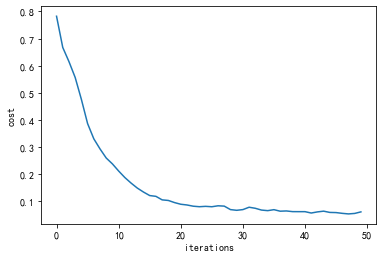

Train Accuracy: 98.52%
Test Accuracy: 75.25%


In [13]:
# 训练模型
max_len = 100
batch_size = 500
hidden_dim = 100
params_save_path = r'C:\Users\12517\PycharmProjects\NLP\projects\taptap评论情感分析\data\emo_parms.pkl'
pred_y_test = train_model(X_train, y_train, X_test, y_test, word_to_vec, word_to_index, params_save_path, 
                    max_len=max_len, batch_size=batch_size, hidden_dim=hidden_dim, lr=0.003, epochs=50)

In [37]:
# 从正向情感和负向情感分类准度看测试准度
# 混淆矩阵
def confuse_matrix(y, pred_y):
    fp = np.sum((pred_y>=3)&(y<3))
    fn = np.sum((pred_y<3)&(y>=3))
    tp = np.sum((pred_y>=3)&(y>=3))
    tn = np.sum((pred_y<3)&(y<3))
    confuse_matrix = np.array([[tp, fp], [fn, tn]])
    precision = tp / (fp+tp)
    recall = tn / (fn + tn)
    F1 = 2 * (precision*recall) / (precision+recall)
    print(confuse_matrix)
    print('Precision = %.2f,   Recall = %.2f    F1 = %.2f' % (precision, recall, F1))

In [38]:
# 混淆矩阵
confuse_matrix(y_test, pred_y_test)
# 负类情感的预测准度为0.29，站在游戏商的角度，关注玩家意见比听从赞美更重要，那么这个结果显然是不可接受的，所以接下来要优化负类预测准度

[[1750  117]
 [  77   32]]
Precision = 0.94,   Recall = 0.29    F1 = 0.45
